In [2]:
import numpy as np
import yfinance as yf
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

In [3]:
START = "2015-01-01"
END = "2025-01-01"
TICKER = "^GSPC"
TITLE = TICKER + " - " +(datetime.now()).strftime("%Y-%m-%d - %H:%M:%S")

In [4]:
data = pd.read_csv("data.csv",index_col=0)

# data = yf.download(TICKER,start=START, end=END,multi_level_index=False)

data["log_return"] = np.log(data["Close"] / data["Close"].shift(1))
data["high_log_return"] = np.log(data["High"] / data["High"].shift(1))
data["low_log_return"] = np.log(data["Low"] / data["Low"].shift(1))
data["open_log_return"] = np.log(data["Open"] / data["Open"].shift(1))

data["cum_log_return"] = data["log_return"].cumsum()
data["cum_high_log_return"] = data["high_log_return"].cumsum()
data["cum_low_log_return"] = data["low_log_return"].cumsum()
data["cum_open_log_return"] = data["open_log_return"].cumsum()

data.dropna(inplace=True)
data.drop(columns=["Volume"],inplace=True)

data.index = pd.to_datetime(data.index)

<Axes: xlabel='Date'>

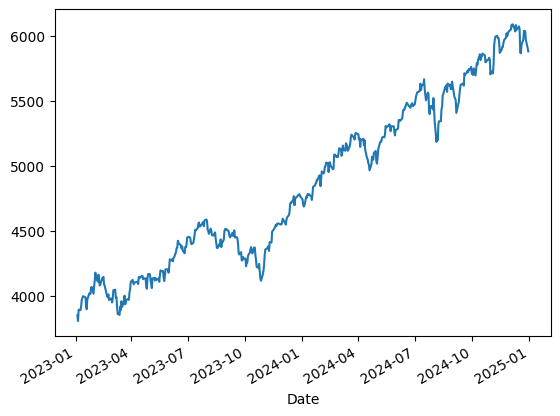

In [5]:
data["Adj Close"].plot()

In [6]:
data = data.asfreq("B")
data.dropna(inplace=True)

In [7]:
def ichimoku(data_, short=9, medium=26, long=52):
    index2 = pd.date_range(data.index[-1],periods=medium, freq="B")
    index2 = data_.index.union(index2)
    print(len(data.index))
    data_ = data_.reindex(index2)
    data_["tenkan"] = ((data_["cum_high_log_return"].rolling(short).max()) + (data_["cum_low_log_return"].rolling(short).min())) / 2
    data_["kijin"] = ((data_["cum_high_log_return"].rolling(medium).max()) + (data_["cum_low_log_return"].rolling(medium).min())) / 2
    data_["chikou"] = data_["cum_log_return"].shift(-medium)
    data_["span_a"] = (((data_["tenkan"] + data_["kijin"])) / 2).shift(medium)
    data_["span_b"] = (((data_["cum_high_log_return"].rolling(long).max()) + (data_["cum_low_log_return"].rolling(long).min())) / 2).shift(medium)
    return data_

In [16]:
data_ichi = ichimoku(data)[-90:]
data_ichi *= 100

501


C:\Users\olive\AppData\Local\Temp\ipykernel_23840\680360353.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


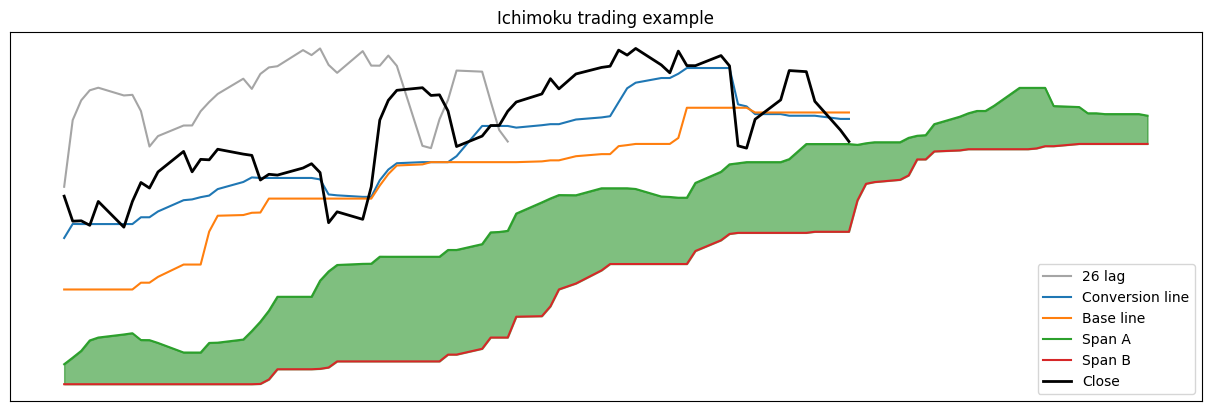

In [17]:
fig, ax1 = plt.subplots(figsize=(12,4),layout='constrained')

lagged, = ax1.plot(data_ichi["chikou"], label="26 lag", color="tab:grey",alpha=0.7)
conv, = ax1.plot(data_ichi["tenkan"], label="Conversion line", color="tab:blue")
base, = ax1.plot(data_ichi["kijin"], label="Base line", color="tab:orange")
fast, = ax1.plot(data_ichi["span_a"], label="Span A",color="tab:green")
slow, = ax1.plot(data_ichi["span_b"], label="Span B",color="tab:red")
price, = ax1.plot(data_ichi["cum_log_return"], label="Close",lw=2,color="black")

plt.fill_between(data_ichi.index,data_ichi["span_a"],data_ichi["span_b"],data_ichi["span_a"] > data_ichi["span_b"],color="green",alpha=0.5)
plt.fill_between(data_ichi.index,data_ichi["span_b"],data_ichi["span_a"],data_ichi["span_a"] < data_ichi["span_b"],color="red",alpha=0.5)

ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
# ax1.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax1.xaxis.get_major_locator()))
# ax1.xaxis.set_major_locator(mdates.YearLocator())

# ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_locator(mdates.MonthLocator())
# ax1.xaxis.set_minor_locator(mdates.DayLocator())
# fig.autofmt_xdate()

ax1.yaxis.set_visible(False)
ax1.xaxis.set_visible(False)
# ax1.grid(True)
# ax1.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax1.xaxis.get_major_locator()))

ax1.legend(loc=4)
plt.title("Ichimoku trading example")
fig.show()
fig.savefig("Ichimoku Example.png", transparent=True)

In [14]:
from matplotlib.animation import FuncAnimation
import numpy as np

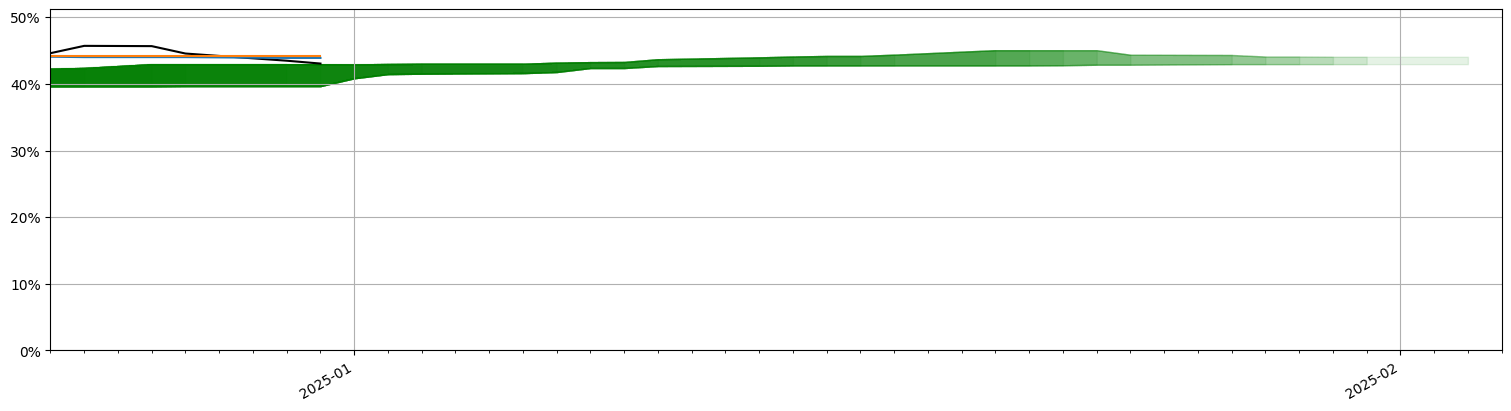

In [ ]:
from textwrap import fill


fig, ax1 = plt.subplots(figsize=(15,4),layout='constrained')
total_frames = len(data_ichi)

price, = ax1.plot([],[],color="black")
tenkan, = ax1.plot(data_ichi["tenkan"], label="Conversion line", color="tab:blue")
kijin, = ax1.plot(data_ichi["kijin"], label="Base line", color="tab:orange")
chikou, = ax1.plot(data_ichi["chikou"], label="26 lag", color="tab:grey",alpha=0.7)



ax1.set(ylim=[0,data_ichi["cum_log_return"].max()*1.1])
ax1.set_xlim(data_ichi.index[0],data_ichi.index[-1])

ax1.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_minor_locator(mdates.DayLocator())
fig.autofmt_xdate()

ax1.grid(True)

fill_artist_g = None
fill_artist_r = None

def animation(frame):
    global fill_artist
    window = 30
    min_frame = max(0,frame - window)

    if fill_artist_g is not None:
        fill_artist_g.remove()

    if fill_artist_r is not None:
        fill_artist_r.remove()

    if frame > window:
        ax1.set_xlim(data_ichi.index[frame-window],data_ichi.index[frame])
    else:
        ax1.set_xlim(data_ichi.index[0],data_ichi.index[window])

    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_minor_locator(mdates.DayLocator())

    # ax1.set_ylim(data_ichi["cum_log_return"][min_frame:frame+1].min()*0.8,data_ichi["cum_log_return"][min_frame:frame+1].max()*1.2)
    fig.autofmt_xdate()

    # ax1.set(ylim=[data_ichi["cum_log_return"].min()*0.9,data_ichi["cum_log_return"].max()*1.1])

    price.set_data(data_ichi["cum_log_return"].index[min_frame:frame],data_ichi["cum_log_return"][min_frame:frame].values)
    tenkan.set_data(data_ichi["tenkan"].index[min_frame:frame],data_ichi["tenkan"][min_frame:frame].values)
    kijin.set_data(data_ichi["kijin"].index[min_frame:frame],data_ichi["kijin"][min_frame:frame].values)
    chikou.set_data(data_ichi["chikou"].index[min_frame:frame],data_ichi["chikou"][min_frame:frame].values)

    if frame > window:
        fill_artist = ax1.fill_between(data_ichi.index[min_frame:frame],data_ichi["span_a"][min_frame:frame],data_ichi["span_b"][min_frame:frame],data_ichi["span_a"][min_frame:frame] > data_ichi["span_b"][min_frame:frame],color="green",alpha=0.1)
        fill_artist = ax1.fill_between(data_ichi.index[min_frame:frame],data_ichi["span_b"][min_frame:frame],data_ichi["span_a"][min_frame:frame],data_ichi["span_a"][min_frame:frame] < data_ichi["span_b"][min_frame:frame],color="red",alpha=0.1)


    return price, tenkan, kijin, chikou,

ani = FuncAnimation(fig,func=animation, frames=total_frames,interval=100, blit=True)
ani.save("animation.mp4",dpi=120,fps=24)